# Problem 1

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [5]:
import TasmanianSG
import numpy as np

# imports specifically needed by the examples
import math
from random import uniform
from datetime import datetime

print("TasmanianSG version: {0:s}".format(TasmanianSG.__version__))
print("TasmanianSG license: {0:s}".format(TasmanianSG.__license__))

grid  = TasmanianSG.TasmanianSparseGrid()
grid1 = TasmanianSG.TasmanianSparseGrid()
grid2 = TasmanianSG.TasmanianSparseGrid()

TasmanianSG version: 4.0
TasmanianSG license: BSD 3-Clause


### Static Sparse Grid

In [6]:
# EXAMPLE 1 for OSM:
# interpolate: f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)
# using piecewise linear basis functions.

# 1000 2-dimensional sample points 
aPnts = np.empty([1000, 2])  
for iI in range(1000):
    for iJ in range(2):
        aPnts[iI][iJ] = uniform(-1.0, 1.0)
        
### (Kei Comment) This is generating 1000 points on (x,y) grid uniformly so that we can use this 
### to evaluate how well the function is interpolating.

# Result
aTres = np.empty([1000,])
for iI in range(1000):
    aTres[iI] = math.cos(0.5 * math.pi * aPnts[iI][0]) * math.cos(0.5 * math.pi * aPnts[iI][1])
### (Kei Comment) Getting the actual value of the function at these 1000 uniformly generated grid points.

# Sparse Grid with dimension 2 and 1 output and refinement level 5
iDim = 2
iOut = 1
iDepth = 2
which_basis = 1 #1= linear basis functions -> Check the manual for other options

print("\n-------------------------------------------------------------------------------------------------")
print("Example 1 for OSM: interpolate f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)")
print("       using fixed sparse grid with depth {0:1d}".format(iDepth))
print("       the error is estimated as the maximum from 1000 random points\n")

# construct sparse grid
grid.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")  
### (Kei Comment) Creates sparse grid of points to evaluate function and interpolate
aPoints = grid.getPoints()
iNumP1 = aPoints.shape[0]
aVals = np.empty([aPoints.shape[0], 1])
for iI in range(aPoints.shape[0]):
    aVals[iI] = math.cos(0.5 * math.pi * aPoints[iI][0]) * math.cos(0.5 * math.pi * aPoints[iI][1])
grid.loadNeededPoints(aVals)  
### (Kei Comment) Load these values and interpolate (based on sparse grid of points)

# compute the error
aRes = grid.evaluateBatch(aPnts)  
### (Kei Comment) evaluate how well the interpolation is doing by finding the error at the 1000 unformly 
### generated data points based on interpolation. 

fError1 = max(np.fabs(aRes[:,0] - aTres))
print(" For localp    Number of points: {0:1d}   Max. Error: {1:1.16e}".format(iNumP1, fError1))

# write coordinates of grid to a text file
f=open("fix_sparse_grid.txt", 'a')
np.savetxt(f, aPoints, fmt='% 2.16f')
f.close()


-------------------------------------------------------------------------------------------------
Example 1 for OSM: interpolate f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)
       using fixed sparse grid with depth 2
       the error is estimated as the maximum from 1000 random points

 For localp    Number of points: 13   Max. Error: 1.9496368470374689e-01


### Adaptive Sparse Grid

In [22]:
## EXAMPLE 2 for OSM:
## interpolate: f(x,y) = exp(-x) / (1 + 100 * exp(-10 * y))
## using refinement

aTres = np.empty([1000,])
for iI in range(1000):
    aTres[iI] = math.cos(0.5 * math.pi * aPnts[iI][0]) * math.cos(0.5 * math.pi * aPnts[iI][1])

# Adaptive Sparse Grid with dimension 2 and 1 output and maximum refinement level 5, refinement criterion.
iDim = 2
iOut = 1
iDepth = 1
fTol = 1.E-5
which_basis = 1 
refinement_level = 5

# level of grid before refinement
grid1.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")

aPoints = grid1.getPoints()
print(aPoints)
aVals = np.empty([aPoints.shape[0], 1])
for iI in range(aPoints.shape[0]):
    aVals[iI] = math.cos(0.5 * math.pi * aPoints[iI][0]) * math.cos(0.5 * math.pi * aPoints[iI][1])
grid1.loadNeededPoints(aVals)

### (Kei Comment) Initializing the sparse grid at that level iDepth (in this case 1). This is the 
### static sparse grid. We do this because sometimes we check at areas that may not be helpful.

print("\n-------------------------------------------------------------------------------------------------")
print("Example 2: interpolate f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)")
print("   the error is estimated as the maximum from 1000 random points")
print("   tolerance is set at 1.E-5 and piecewise linear basis functions are used\n")

print("               Classic refinement ")
print(" refinement level         points     error   ")

#refinement level
for iK in range(refinement_level):
    grid1.setSurplusRefinement(fTol, -1, "fds")   #also use fds, or other rules
    aPoints = grid1.getNeededPoints()
    aVals = np.empty([aPoints.shape[0], 1])
    for iI in range(aPoints.shape[0]):
        aVals[iI] = math.cos(0.5 * math.pi * aPoints[iI][0]) * math.cos(0.5 * math.pi * aPoints[iI][1])
    grid1.loadNeededPoints(aVals)

    aRes = grid1.evaluateBatch(aPnts)
    fError1 = max(np.fabs(aRes[:,0] - aTres))

    print(" {0:9d} {1:9d}  {2:1.2e}".format(iK+1, grid1.getNumPoints(), fError1))
    
### (Kei Comment) For each level, look at the possible grid surplus (coefficient). If coefficient bigger 
### than threshold evaluate function at that grid point. If not, do not evaluate function at that grid point. 
### Continue until threshold is met at that area in which case don't check children or stop because refinement level
### has been reached. 

### (Kei Comment) For value function, during each iteration the sparse grid evolves and gets bigger until some threshold.
### Also, for each iteration, has new sparse grid because the function has changed as new value function update.

# write coordinates of grid to a text file
f2=open("Adaptive_sparse_grid.txt", 'a')
np.savetxt(f2, aPoints, fmt='% 2.16f')
f2.close()
 
grid2 = TasmanianSG.TasmanianSparseGrid()
grid2.makeLocalPolynomialGrid(iDim, iOut, refinement_level+iDepth, which_basis, "localp")
a = grid2.getNumPoints()
 
print("\n-------------------------------------------------------------------------------------------------")
print "   a fix sparse grid of level ", refinement_level+iDepth, " would consist of " ,a, " points"
print("\n-------------------------------------------------------------------------------------------------\n")    

[[ 0.  0.]
 [ 0. -1.]
 [ 0.  1.]
 [-1.  0.]
 [ 1.  0.]]

-------------------------------------------------------------------------------------------------
Example 2: interpolate f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)
   the error is estimated as the maximum from 1000 random points
   tolerance is set at 1.E-5 and piecewise linear basis functions are used

               Classic refinement 
 refinement level         points     error   
         1         9  9.41e-01
         2        25  9.11e-01
         3        61  8.32e-01
         4       141  6.66e-01
         5       317  7.49e-01

-------------------------------------------------------------------------------------------------
   a fix sparse grid of level  6  would consist of  321  points

-------------------------------------------------------------------------------------------------



In [11]:
def oscillatory_func(x, c, w):
    return np.cos(2*np.pi*w[0] + np.sum(c * x))

In [12]:
c = np.array([2,2])
w = np.array([2,2])
x = np.array([3,3])
oscillatory_func(x,c,w)

0.8438539587324918

[[ 0.  0.]
 [ 0. -1.]
 [ 0.  1.]
 [-1.  0.]
 [ 1.  0.]]

-------------------------------------------------------------------------------------------------
Example 2: interpolate f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)
   the error is estimated as the maximum from 1000 random points
   tolerance is set at 1.E-5 and piecewise linear basis functions are used

               Classic refinement 
 refinement level         points     error   


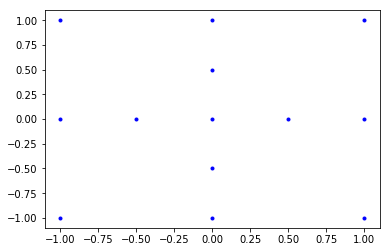

         1        13  1.12e+00


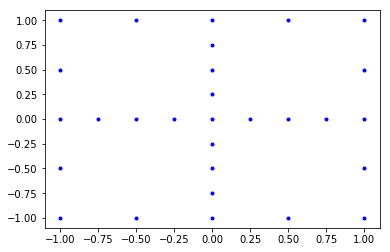

         2        29  1.36e+00


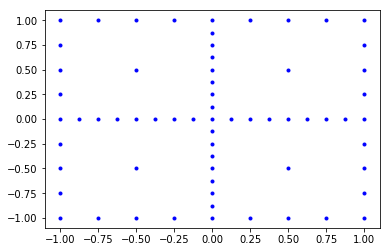

         3        65  1.37e+00


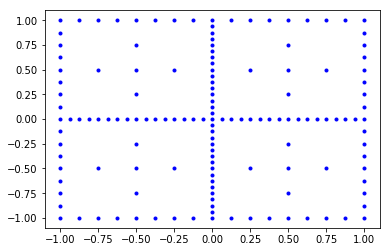

         4       145  1.39e+00


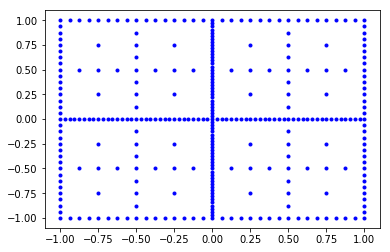

         5       321  1.40e+00


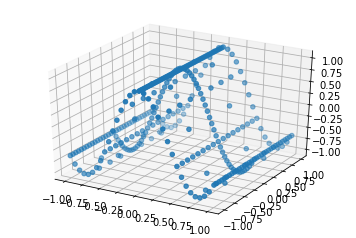


-------------------------------------------------------------------------------------------------
   a fix sparse grid of level  6  would consist of  321  points

-------------------------------------------------------------------------------------------------



In [25]:
## EXAMPLE 2 for OSM:
## interpolate: f(x,y) = exp(-x) / (1 + 100 * exp(-10 * y))
## using refinement

aTres = np.empty([1000,])
for iI in range(1000):
    aTres[iI] = math.cos(0.5 * math.pi * aPnts[iI][0]) * math.cos(0.5 * math.pi * aPnts[iI][1])

# Adaptive Sparse Grid with dimension 2 and 1 output and maximum refinement level 5, refinement criterion.
iDim = 2
iOut = 1
iDepth = 1
fTol = 0 # 1.E-5
which_basis = 1 
refinement_level = 5

# level of grid before refinement
grid1.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")

aPoints = grid1.getPoints()
print(aPoints)
aVals = np.empty([aPoints.shape[0], 1])
for iI in range(aPoints.shape[0]):
    aVals[iI] = oscillatory_func(aPoints[iI][0], c, w)    
grid1.loadNeededPoints(aVals)

### (Kei Comment) Initializing the sparse grid at that level iDepth (in this case 1). This is the 
### static sparse grid. We do this because sometimes we check at areas that may not be helpful.

print("\n-------------------------------------------------------------------------------------------------")
print("Example 2: interpolate f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)")
print("   the error is estimated as the maximum from 1000 random points")
print("   tolerance is set at 1.E-5 and piecewise linear basis functions are used\n")

print("               Classic refinement ")
print(" refinement level         points     error   ")

#refinement level
for iK in range(refinement_level):
    grid1.setSurplusRefinement(fTol, -1, "fds")   #also use fds, or other rules
    aPoints = grid1.getNeededPoints()
    aVals = np.empty([aPoints.shape[0], 1])
    for iI in range(aPoints.shape[0]):
        aVals[iI] = oscillatory_func(aPoints[iI][0], c, w)    
    grid1.loadNeededPoints(aVals)
    grid1.plotPoints2D()
    grid_points = grid1.getPoints()

    aRes = grid1.evaluateBatch(aPnts)
    fError1 = max(np.fabs(aRes[:,0] - aTres))

    print(" {0:9d} {1:9d}  {2:1.2e}".format(iK+1, grid1.getNumPoints(), fError1))


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(grid_points[:,0], grid_points[:,1], grid1.evaluateBatch(grid_points))
plt.show()
    
### (Kei Comment) For each level, look at the possible grid surplus (coefficient). If coefficient bigger 
### than threshold evaluate function at that grid point. If not, do not evaluate function at that grid point. 
### Continue until threshold is met at that area in which case don't check children or stop because refinement level
### has been reached. 

### (Kei Comment) For value function, during each iteration the sparse grid evolves and gets bigger until some threshold.
### Also, for each iteration, has new sparse grid because the function has changed as new value function update.

# write coordinates of grid to a text file
f2=open("Adaptive_sparse_grid.txt", 'a')
np.savetxt(f2, aPoints, fmt='% 2.16f')
f2.close()
 
grid2 = TasmanianSG.TasmanianSparseGrid()
grid2.makeLocalPolynomialGrid(iDim, iOut, refinement_level+iDepth, which_basis, "localp")
a = grid2.getNumPoints()
 
print("\n-------------------------------------------------------------------------------------------------")
print "   a fix sparse grid of level ", refinement_level+iDepth, " would consist of " ,a, " points"
print("\n-------------------------------------------------------------------------------------------------\n")    

## Problem 2 